In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel
from e6dataflow.tools.fittools import e6_fit

In [12]:
import e6dataflow
print(e6dataflow.__file__)

c:\python37-32\lib\site-packages\e6dataflow\__init__.py


In [2]:
data_root = Path('Y:/', 'expdata-e6/data')
daily_subpath = Path(*Path.cwd().parent.parts[-3:])
daily_path = Path(data_root, daily_subpath)

run_name = 'run0'

datamodel = load_datamodel(daily_path=daily_path, run_name=run_name)


Loading datamodel from Y:\expdata-e6\data\2021\01\20\analysis\run0\run0-datamodel.p


In [3]:
num_points = datamodel.num_points
num_frames = 3
num_tweezers = 10
survival_probability_array = np.zeros([num_points, num_frames, num_tweezers])
for point_num in range(num_points):
    for frame_num in range(num_frames):
        frame_key = f'frame-{frame_num:02d}'
        for tweezer_num in range(num_tweezers):
            tweezer_key = f'tweezer-{tweezer_num:02d}'
            datafield_name = f'{frame_key}_{tweezer_key}_counts_verifier'
            verified_list = datamodel.get_data_by_point(datafield_name, point_num)
            num_above = np.sum(np.array(verified_list))
            num_total = len(verified_list)
            frac_above = num_above / num_total
            survival_probability_array[point_num, frame_num, tweezer_num] = frac_above

In [4]:
init_prob = np.mean(survival_probability_array[:, 0, :])
survival_probability_list = [init_prob]
for point_num in range(num_points):
    new_prob = np.mean(survival_probability_array[point_num, 1, :])
    survival_probability_list.append(new_prob)

lifetime_data = np.array(survival_probability_list) / init_prob
t_data = np.array([0, 5, 20, 30, 40, 60])

In [5]:
def exp_func(t, tau, amplitude):
    return amplitude * np.exp(- t / tau)

fit_struct = e6_fit(input_data=t_data, output_data=lifetime_data, fit_func=exp_func, param_guess=[20, 0.5],
                   param_keys=['tau', 'amplitude'])

t_plot_list = np.linspace(0, 65, 100)
lifetime_model = exp_func(t_plot_list, **fit_struct['kwargs'])

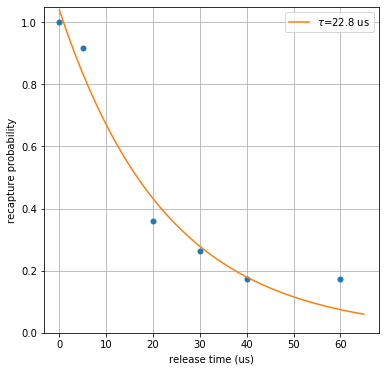

In [6]:
tau = fit_struct['tau']['val']
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(t_data, lifetime_data, '.', markersize=10)
ax.plot(t_plot_list, lifetime_model, markersize=10, label=f'$\\tau$={tau:.01f} us')
ax.grid(True)
ax.legend()
ax.set_ylim(0, 1.05)
ax.set_xlabel('release time (us)')
ax.set_ylabel('recapture probability')
plt.show()


In [7]:
save_path = Path.cwd()

In [8]:
datamodel.last_handled_shot

273